In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import curve_fit

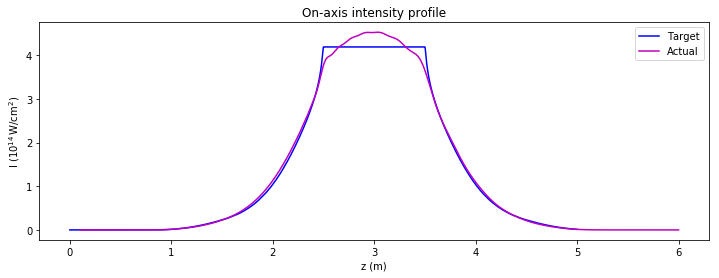

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 2.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 1000,
          'M' : 1000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 10e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 6e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 10e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:5000]/1e6, I[0:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

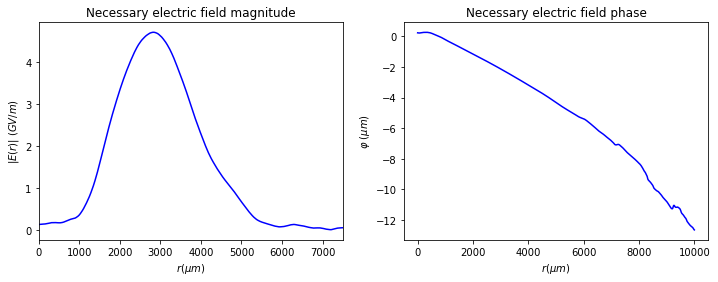

In [3]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

Gaussian (r0, sigma):  [ 2874.64766077   960.72323186]


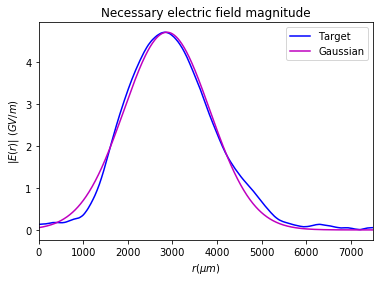

In [4]:
def gaussian(r, r0, sigma):
    return np.exp(-(r-r0)**2/(2*sigma**2))
Emax = np.amax(abs(E))
# Fit the Gaussian
gaussianPopt, gaussianPcov = curve_fit(gaussian, rm, abs(E)/Emax, p0=[2e3, 1e3])
print('Gaussian (r0, sigma): ', gaussianPopt)

plt.plot(rm, abs(E), 'b-', rm, gaussian(rm, *gaussianPopt)*Emax, 'm-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])
plt.legend(['Target', 'Gaussian'])
plt.show()

In [5]:
# Propagation through 3 axicon lenses
lam = 0.8
w0 = 2*gaussianPopt[1] # Initial Gaussian width
eta = 1.1*(gaussianPopt[0]/w0 + 0.5)
beta = 2.273  # Deflection angle, 5.0 deg physical
l = w0/np.tan(np.radians(beta))
L = eta*l # Spacing between axicons in telescope
L2 = 10e4
print('l: ', l/1e4, 'cm')
print('eta: ', eta, '. Must be larger than 2, preferably around 3')
print('z_r: ', np.pi*w0**2/lam/1e4, 'cm')

def Efunc(x, y):
    # Input Gaussian beam
    r2 = x**2 + y**2
    E0 = np.exp(-r2 / params['w0']**2)
    # Input flatop beam
    #E0 = np.zeros((np.size(x), np.size(y)))
    #E0[r2 < params['w0']**2] = 1.0
    # Axicon lens
    beta = np.radians(params['beta'])
    T0 = np.exp(-1j*2*np.pi*beta*np.sqrt(r2)/params['lam'])
    # Initial electric field
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**11,
          'X' : 15e3,
          'Y' : 15e3,
          'lam' : lam,
          'E0' : ionization.field_from_intensity(1.0)*0.5,
          'n' : 1.0,
          'w0' : w0,
          'beta' : beta
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

l:  4.84087165467 cm
eta:  2.19569374508 . Must be larger than 2, preferably around 3
z_r:  1449.8279323 cm


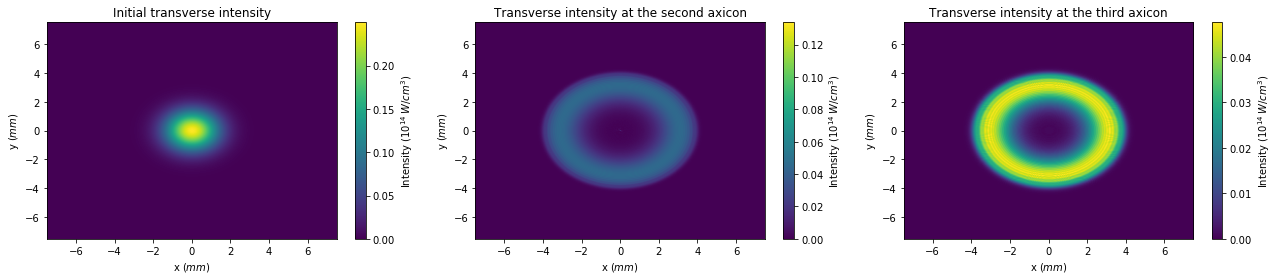

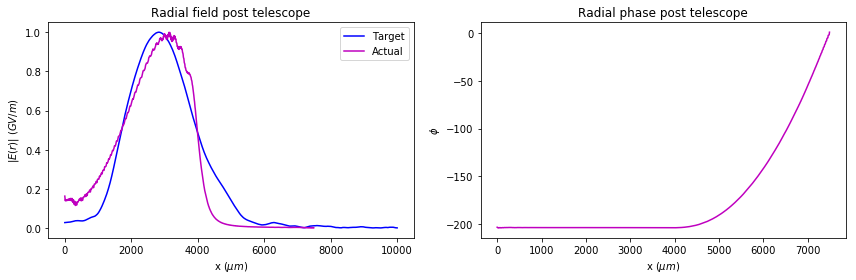

In [6]:
# Initialize the grid
X = params['X']
Y = params['Y']
Nx = params['Nx']
Ny = params['Ny']

x = np.linspace(-X/2, X/2, Nx, False)
y = np.linspace(-Y/2, Y/2, Ny, False)
xe = np.reshape(x, (Nx, 1))
ye = np.reshape(y, (1, Ny))
# Calculate the initial electric field on the boundary
E1 = Efunc(xe, ye) * params['E0']
# Propogate the field through the telescope
E2 = laser.fourier_prop2(E1, x, y, [L], params['lam'], n=params['n'])
# Apply phase of second axicon
r2 = xe**2 + ye**2
T1 = np.exp(-1j*2*np.pi*np.radians(beta)*np.sqrt(r2)/params['lam'])
E3 = E2[0, :, :] * T1
# Propogate the field to the final axilens
E4 = laser.fourier_prop2(E3, x, y, [L2], params['lam'], n=params['n'])

plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.imshow(propagation.prep_data(E1[:, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial transverse intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(132)
plt.imshow(propagation.prep_data(E2[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the second axicon')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(133)
plt.imshow(propagation.prep_data(E4[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the third axicon')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E)/Emax, 'b-', 
         x[int(Nx/2):], abs(E4[0, :, int(Ny/2)])[int(Nx/2):]/np.amax(abs(E4)), 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title('Radial field post telescope')
plt.legend(['Target', 'Actual'])

plt.subplot(122)
plt.plot(x[int(Nx/2):], np.unwrap(np.angle(E4[0, :, int(Ny/2)]))[int(Nx/2):], 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$')
plt.title('Radial phase post telescope')

plt.tight_layout()
plt.show()

Phase (m, b):  [-0.00824285  7.48710924]


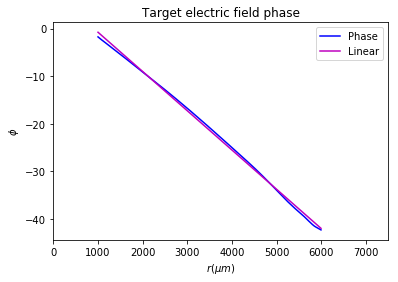

Angle:  0.0601326007614 deg


In [7]:
# We need the extract the phase for the final axicon
def line(x, m, b):
    return m*x + b
# Fit the linear phase, intercept doesn't matter, constant phase
a = 100
b = 600
phasePopt, phasePcov = curve_fit(line, rm[a:b], phi[a:b], p0=[-2e-2, 10])
print('Phase (m, b): ', phasePopt)

plt.plot(rm[a:b], phi[a:b], 'b-', rm[a:b], line(rm[a:b], *phasePopt), 'm-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\phi$')
plt.title(r'Target electric field phase')
plt.xlim([0, 7500])
plt.legend(['Phase', 'Linear'])
plt.show()

angle = np.degrees(abs(phasePopt[0]*lam/(2*np.pi)))
print('Angle: ', angle, 'deg')

In [8]:
# Now calculate what the plasma density would actually look like
E4Scaled = E4[0, :, int(Ny/2)][int(Nx/2):]*Emax/np.amax(abs(E4))
Efield = interp1d(x[int(Nx/2):], E4Scaled)
# Initial electric field
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    E0 = Efield(r)
    # Axicon lens
    beta = np.radians(params['beta'])
    T0 = np.exp(-1j*2*np.pi*beta*r/params['lam'])
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : 6e6,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield,
          'beta' : angle
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

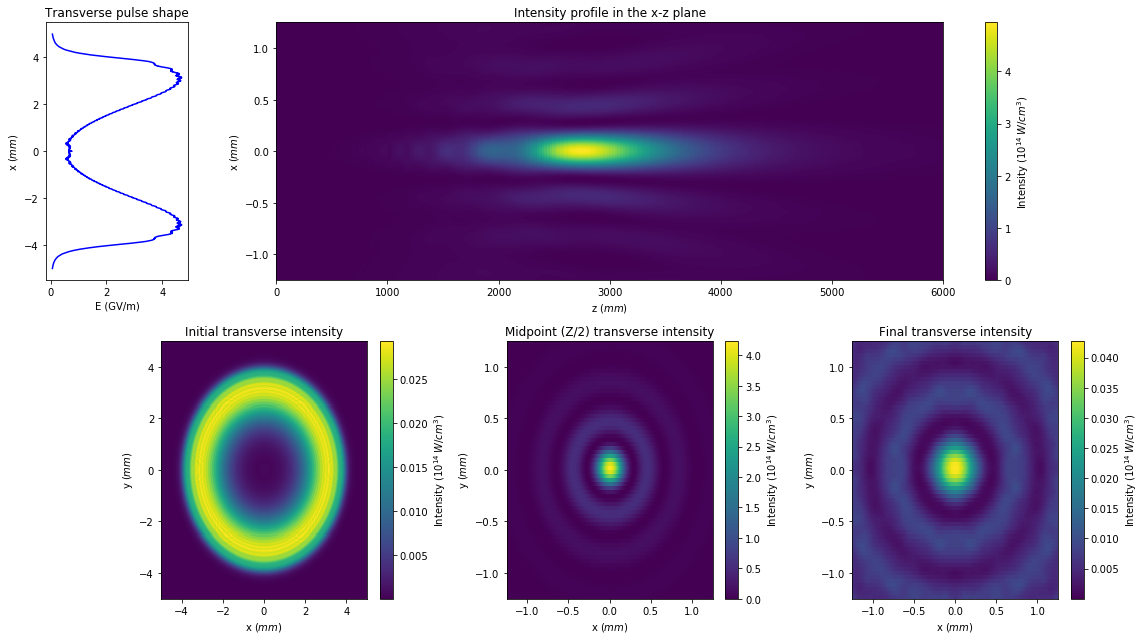

In [9]:
directory = 'PlasmaField'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

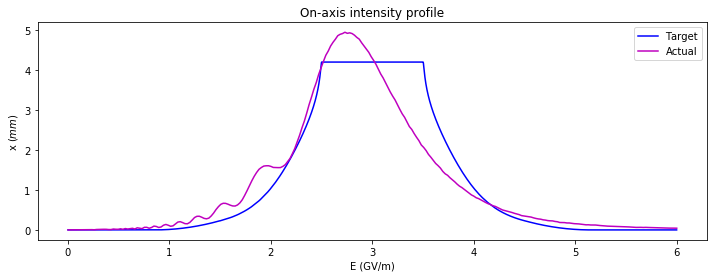

In [10]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:6000]/1e6, I[0:6000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()

In [11]:
# Start flatop beam calculation
def Efunc(x, y):
    # Input Gaussian beam
    r2 = x**2 + y**2
    #E0 = np.exp(-r2 / params['w0']**2)
    # Input flatop beam
    E0 = np.zeros((np.size(x), np.size(y)))
    E0[r2 < params['w0']**2] = 1.0
    # Axicon lens
    beta = np.radians(params['beta'])
    T0 = np.exp(-1j*2*np.pi*beta*np.sqrt(r2)/params['lam'])
    # Initial electric field
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**11,
          'X' : 15e3,
          'Y' : 15e3,
          'lam' : lam,
          'E0' : ionization.field_from_intensity(1.0)*0.5,
          'n' : 1.0,
          'w0' : w0,
          'beta' : beta
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

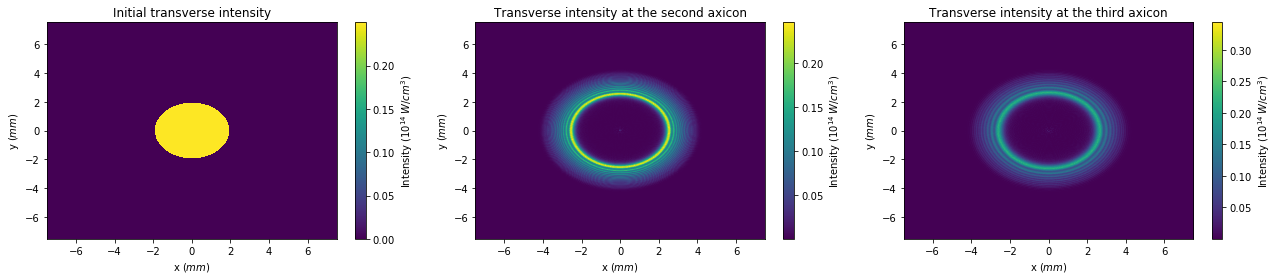

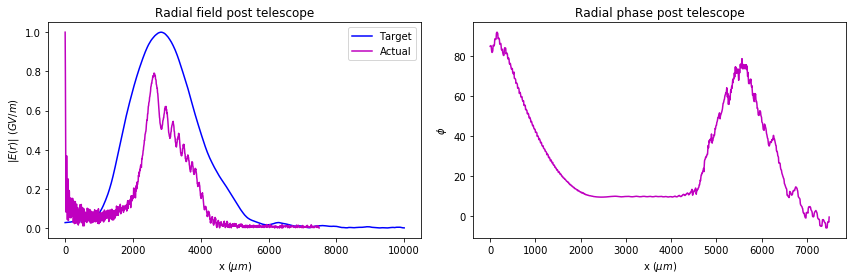

In [12]:
# Initialize the grid
X = params['X']
Y = params['Y']
Nx = params['Nx']
Ny = params['Ny']

x = np.linspace(-X/2, X/2, Nx, False)
y = np.linspace(-Y/2, Y/2, Ny, False)
xe = np.reshape(x, (Nx, 1))
ye = np.reshape(y, (1, Ny))
# Calculate the initial electric field on the boundary
E1 = Efunc(xe, ye) * params['E0']
# Propogate the field through the telescope
E2 = laser.fourier_prop2(E1, x, y, [L], params['lam'], n=params['n'])
# Apply phase of second axicon
r2 = xe**2 + ye**2
T1 = np.exp(-1j*2*np.pi*np.radians(beta)*np.sqrt(r2)/params['lam'])
E3 = E2[0, :, :] * T1
# Propogate the field to the final axilens
E4 = laser.fourier_prop2(E3, x, y, [L2], params['lam'], n=params['n'])

plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.imshow(propagation.prep_data(E1[:, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial transverse intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(132)
plt.imshow(propagation.prep_data(E2[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the second axicon')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(133)
plt.imshow(propagation.prep_data(E4[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the third axicon')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E)/Emax, 'b-', 
         x[int(Nx/2):], abs(E4[0, :, int(Ny/2)])[int(Nx/2):]/np.amax(abs(E4)), 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title('Radial field post telescope')
plt.legend(['Target', 'Actual'])

plt.subplot(122)
plt.plot(x[int(Nx/2):], np.unwrap(np.angle(E4[0, :, int(Ny/2)]))[int(Nx/2):], 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$')
plt.title('Radial phase post telescope')

plt.tight_layout()
plt.show()

In [13]:
# Now calculate what the plasma density would actually look like
E4Scaled = E4[0, :, int(Ny/2)][int(Nx/2):]*Emax/np.amax(abs(E4))
Efield = interp1d(x[int(Nx/2):], E4Scaled)
# Initial electric field
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    E0 = Efield(r)
    # Axicon lens
    beta = np.radians(params['beta'])
    T0 = np.exp(-1j*2*np.pi*beta*r/params['lam'])
    return E0 * T0 * 2

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : 6e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield,
          'beta' : angle
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

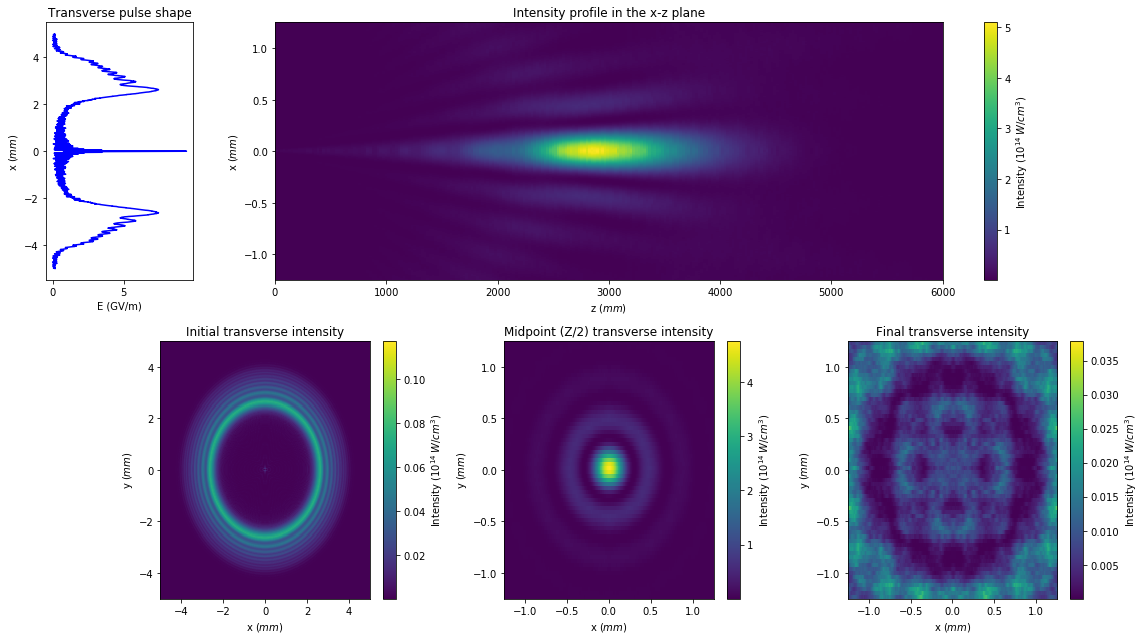

In [14]:
directory = 'PlasmaFlatopField'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

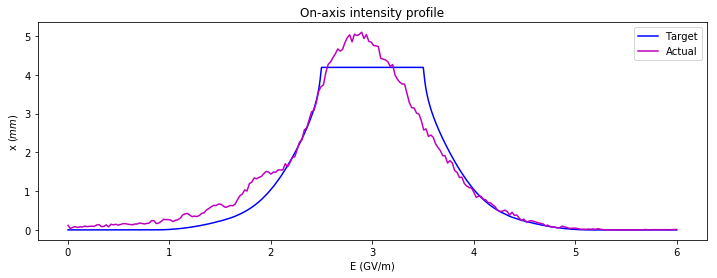

In [15]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:6000]/1e6, I[0:6000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()